In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import statsmodels.api as sm
from torchmin import minimize
import scipy.stats as stats

In [7]:

# Parameter für die Simulation
num_rats = 50 # Anzahl der Ratten
def time(t):
    return np.log(1 + (45 + t- 45)/10) # transformierte Alter
b_0 = 68.607
b_1 = 7.505
b_2 = 6.874
b_3 = 7.313
noise_var = 1.241
random_effect_0 = 1.743
random_effect_1 = 0.152

grouping = np.random.choice([1,2,3], size= num_rats)
# Indikatorvariablen
C = np.zeros(num_rats)
N = np.zeros(num_rats)
H = np.zeros(num_rats)

for i, group in enumerate(grouping):
    if group == 1:
        C[i] = 1
    if group == 2:
        N[i] = 1
    if group == 3:
        H[i] = 1


def simulate_data(num_patients):
    data = []
    for patient_id in range(num_patients):
        # Randomly generate time points
        num_time_points = np.random.choice([4,5,6,7,8,9,10])
        time_points = [t * 10 for t in range(num_time_points)]

        gamma_0 = np.random.normal(0,random_effect_0 **2)
        gamma_1 = np.random.normal(0,random_effect_1 **2)
    
        for j,t in enumerate(time_points):
            # Generate noise
            noise = np.random.normal(0.0, np.sqrt(noise_var))
        
            # Simulate test score
            test_score = b_0 + gamma_0 + b_1 * N[patient_id] * time(t) \
                        + b_2 * H[patient_id] * time(t) \
                        + b_3 * C[patient_id] * time(t) \
                        + gamma_1 * time(t) + noise
            data.append([patient_id,grouping[patient_id], t, time(t), test_score])
    return data

df = pd.DataFrame(simulate_data(num_rats), columns=['patient_id','group', 'years_after_treatment','age', 'test_score'])
print(df)

     patient_id  group  years_after_treatment       age  test_score
0             0      1                      0  0.000000   65.386279
1             0      1                     10  0.693147   71.416371
2             0      1                     20  1.098612   71.489402
3             0      1                     30  1.386294   74.758763
4             0      1                     40  1.609438   76.138703
..          ...    ...                    ...       ...         ...
366          48      3                     90  2.302585   88.240827
367          49      2                      0  0.000000   71.477542
368          49      2                     10  0.693147   76.620773
369          49      2                     20  1.098612   80.557643
370          49      2                     30  1.386294   79.445469

[371 rows x 5 columns]


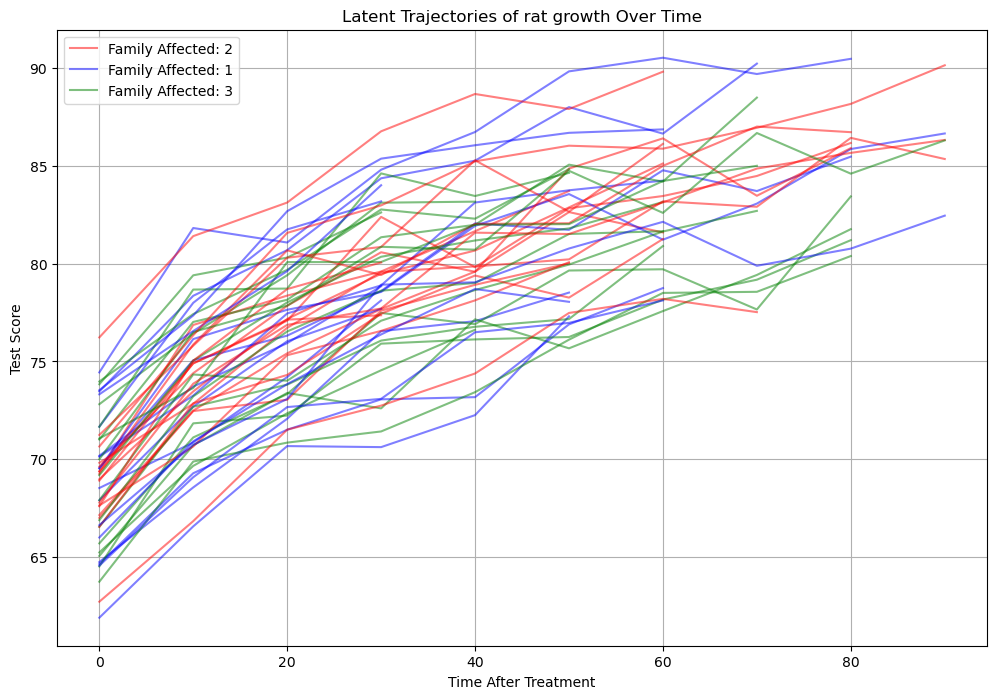

In [4]:
# plot the dataset

color_effect = 'group'

# Assuming you have your data in a DataFrame named 'df'
marker_map = {1: 'blue', 2: 'red', 3: 'green'} 

plt.figure(figsize=(12, 8))
# Create a set to track which labels have already been added to the legend
added_labels = set()


for patient_id in df['patient_id'].unique():
    patient_data = df[df['patient_id'] == patient_id]
    
    label = patient_data[color_effect].iloc[0]
    color = marker_map[label]

    # Check if the label has been added to the legend
    if label not in added_labels:
        plt.plot(patient_data['years_after_treatment'], patient_data['test_score'],
                 alpha=0.5, color=color, label=f'Family Affected: {label}')
        added_labels.add(label)
    else:
        plt.plot(patient_data['years_after_treatment'], patient_data['test_score'],
                 alpha=0.5, color=color)

plt.title('Latent Trajectories of rat growth Over Time')
plt.xlabel('Time After Treatment')
plt.ylabel('Test Score')
plt.grid(True)
plt.legend()
plt.show()

In [5]:
def get_ind(pat, df):
    return np.where(df['patient_id'] == pat)[0]

# returns a block diagonal matrix of a list of matrices
def block_diag_list(arrs_list):
    shape = torch.sum(torch.tensor([a.shape for a in arrs_list], dtype=torch.int32), dim=0)
    dtype = arrs_list[0].dtype
    device = arrs_list[0].device

    out = torch.zeros(*shape.tolist(), dtype=dtype, device=device)

    r, c = 0, 0
    for a in arrs_list:
        rows, cols = a.shape
        out[r:r + rows, c:c + cols] = a
        r += rows
        c += cols
    return out

def calculate_Zlist(df, random_effects_keys):
    Z_list = [torch.cat((
        torch.ones(len(get_ind(pat, df)), 1), 
        torch.from_numpy(np.array(df.loc[get_ind(pat, df), random_effects_keys]))
                        ), -1).to(torch.float32)
                for pat in df['patient_id'].unique()]
    return Z_list

# Fixed effects design matrix (Datenmatrix) for each patient
def calculate_Xlist(df, fixed_effects_keys):
    X_list = [torch.cat((
        torch.ones(len(get_ind(pat, df)), 1), 
        torch.from_numpy(np.array(df.loc[get_ind(pat, df), fixed_effects_keys]))
                         ), -1).to(torch.float32)
                for pat in df['patient_id'].unique()]
    return X_list

def likelihood_ratio(Lmin, Lmax):
    return 2 * (Lmax - Lmin)

In [16]:
num_simulations  = 100
#keys for random and fixed effects in the matrix
fixed_effects_keys = ['group', 'age']
random_effects_keys = ['years_after_treatment']
#keys for random and fixed effects in the matrix
fixed_effects_keys_r = ['group']
random_effects_keys_r = ['years_after_treatment']

n_fixed_eff = len(fixed_effects_keys) + 1
n_rand_eff = len(random_effects_keys) + 1
n_fixed_eff_r = len(fixed_effects_keys_r) + 1
n_rand_eff_r = len(random_effects_keys_r) + 1
softplus = torch.nn.Softplus()
D_param = torch.randn(n_rand_eff, requires_grad=True) # Learnable parameter for diagonal covariance matrix
D_param_r = torch.randn(n_rand_eff_r, requires_grad=True) # Learnable parameter for diagonal covariance matrix
print(D_param)
print(D_param_r)
lrt_results = []

for _ in range(num_simulations):
    grouping = np.random.choice([1,2,3], size= num_rats)
    # Indikatorvariablen
    C = np.zeros(num_rats)
    N = np.zeros(num_rats)
    H = np.zeros(num_rats)

    for i, group in enumerate(grouping):
        if group == 1:
            C[i] = 1
        if group == 2:
            N[i] = 1
        if group == 3:
            H[i] = 1

    data = pd.DataFrame(simulate_data(50), columns=['patient_id','group', 'years_after_treatment','age', 'test_score'])
    N = len(data)
    Z_list = calculate_Zlist(data, random_effects_keys) # Random effects design matrix (Datenmatrix) for each patient
    X_list = calculate_Xlist(data, fixed_effects_keys) # Fixed effects design matrix (Datenmatrix) for each patient
    y = torch.from_numpy(np.array(data['test_score'])).to(torch.float32) # Response variable: Test scores
    X_tilde_list = [torch.cat((X_i, torch.zeros((n_rand_eff, n_fixed_eff)))) for X_i in X_list] # Defining list of X tilde (eq. 2.7 p. 63)
    y_e = torch.cat([torch.cat((y[get_ind(pat,data)], torch.zeros(n_rand_eff))).unsqueeze(-1) for pat in data['patient_id'].unique()]) # Augmented response vector y_e (eq. 2.11 p. 65)

    def calculate_likelihood_full(D_param): 
        # Ensure that the diagonal covariance matrix has only positive values
        Delta = torch.diag(softplus(D_param))
        det_Delta = torch.det(Delta)  

        # Defining list of Z tilde (eq. 2.7 p. 63)
        Z_tilde_list = [torch.cat((Z_i, Delta)) for Z_i in Z_list]
        # Matrix X_e (eq. 2.11 p. 65)
        X_e = torch.cat((block_diag_list(Z_tilde_list), torch.cat(X_tilde_list)), -1)

        # Calculate MLE estimates of random and fixed effects with current set of covariance Parameters (eq. 2.11 p. 65)
        pred = torch.inverse((X_e.t() @ X_e)) @ X_e.t() @ y_e
        # Calculate MLE estimates of the noise sigma with current set of covariance Parameters (eq. 2.12 p. 65)
        pred_sigma = torch.sum((y_e - X_e @ pred) ** 2) / N

        # Calculate the logarithm of the likelihood function in (eq. 2.13 p. 65)
        likelihood = -N/2 * (1 + torch.log(torch.tensor(2 * torch.pi)) + torch.log(pred_sigma))
        likelihood += torch.log(torch.stack([det_Delta/torch.det(Z_i_tilde.t() @ Z_i_tilde).sqrt() for Z_i_tilde in Z_tilde_list])).sum()
        return - likelihood
    
    result_full = minimize(calculate_likelihood_full, D_param, method='bfgs', max_iter=6)
    Lmax = result_full.fun

    N_r = len(data)
    Z_list_r = calculate_Zlist(data, random_effects_keys_r) # Random effects design matrix (Datenmatrix) for each patient
    X_list_r = calculate_Xlist(data, fixed_effects_keys_r) # Fixed effects design matrix (Datenmatrix) for each patient
    y_r = torch.from_numpy(np.array(data['test_score'])).to(torch.float32) # Response variable: Test scores
    X_tilde_list_r = [torch.cat((X_i, torch.zeros((n_rand_eff_r, n_fixed_eff_r)))) for X_i in X_list_r] # Defining list of X tilde (eq. 2.7 p. 63)
    y_e_r = torch.cat([torch.cat((y_r[get_ind(pat,data)], torch.zeros(n_rand_eff_r))).unsqueeze(-1) for pat in data['patient_id'].unique()]) # Augmented response vector y_e (eq. 2.11 p. 65)

    def calculate_likelihood_reduced(D_param_r):
        # Ensure that the diagonal covariance matrix has only positive values
        Delta_r = torch.diag(softplus(D_param_r))
        det_Delta_r = torch.det(Delta_r)  

        # Defining list of Z tilde (eq. 2.7 p. 63)
        Z_tilde_list_r = [torch.cat((Z_i, Delta_r)) for Z_i in Z_list_r]
        # Matrix X_e (eq. 2.11 p. 65)
        X_e_r = torch.cat((block_diag_list(Z_tilde_list_r), torch.cat(X_tilde_list_r)), -1)

        # Calculate MLE estimates of random and fixed effects with current set of covariance Parameters (eq. 2.11 p. 65)
        pred_r = torch.inverse((X_e_r.t() @ X_e_r)) @ X_e_r.t() @ y_e_r
        # Calculate MLE estimates of the noise sigma with current set of covariance Parameters (eq. 2.12 p. 65)
        pred_sigma_r = torch.sum((y_e_r - X_e_r @ pred_r) ** 2) / N_r

        # Calculate the logarithm of the likelihood function in (eq. 2.13 p. 65)
        likelihood = -N_r/2 * (1 + torch.log(torch.tensor(2 * torch.pi)) + torch.log(pred_sigma_r))
        likelihood += torch.log(torch.stack([det_Delta_r/torch.det(Z_i_tilde_r.t() @ Z_i_tilde_r).sqrt() for Z_i_tilde_r in Z_tilde_list_r])).sum()
        return - likelihood
    result_reduced = minimize(calculate_likelihood_reduced, D_param_r, method='bfgs', max_iter=6)
    Lmin = result_reduced.fun

    lrt_results.append(likelihood_ratio(Lmin,Lmax))

tensor([0.2087, 0.5406], requires_grad=True)
tensor([ 0.7571, -0.5254], requires_grad=True)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


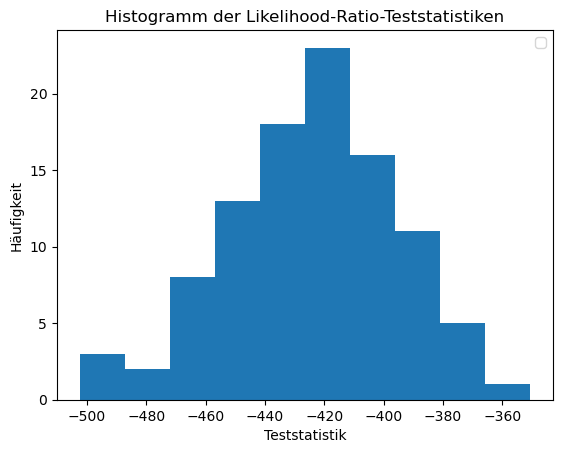

In [18]:
# Histogramm der Teststatistiken erstellen
plt.hist(lrt_results)

# Beschriftungen hinzufügen
plt.title('Histogramm der Likelihood-Ratio-Teststatistiken')
plt.xlabel('Teststatistik')
plt.ylabel('Häufigkeit')
plt.legend()

# Histogramm anzeigen
plt.show()